## Modules à importer

In [14]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from pymage import query
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [10]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

#smap = plt.cm.get_cmap('cividis')
smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          #'HST': smap(0.99),  # for cividis
          'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', index…

## `age` module testing

In [2]:
pdmodel = age.PrompDelayModel()
pdmodel.draw_sample(z=0.04, size=1000)

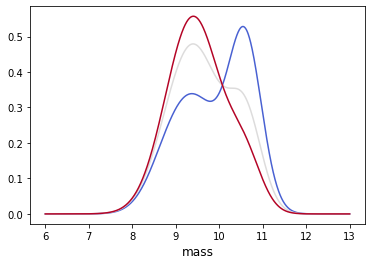

In [6]:
fig = pdmodel.show_pdf("mass", z=[0.05, 0.5, 1], zmax=1)

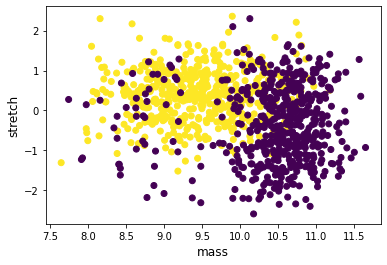

In [13]:
fig = pdmodel.show_scatter("mass","stretch", colorkey="age")

## Fit mass Brodie

NameError: name 'colors' is not defined

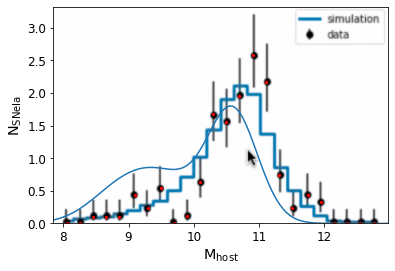

In [51]:
img = plt.imread("../../../Images/png/mass_hist_lowz_crop_zero.png")
fig, ax = plt.subplots()

Mmin = 7.85
Mmax = 12.98
Cmin = 0
Cmax = 170
f = 85.185

Mlist = [8.05, 8.25, 8.45, 8.65, 8.85,
         9.1, 9.3, 9.5, 9.7, 9.9,
         10.1, 10.3, 10.5, 10.7, 10.9,
         11.1, 11.3, 11.5, 11.75, 11.95,
         12.15, 12.35, 12.55, 12.76]

ax.scatter(Mlist,
           np.asarray([0, 0, 8, 8, 8,
                       37, 20, 46, 0, 10,
                       54, 143, 132, 166, 220,
                       185, 63, 20, 37, 28,
                       1, 0, 0, 0])/f,
          color='red', s=5)
ax.imshow(img, extent=[Mmin, Mmax, 0, 3.32])
          #[7.81, 12.94, 0, 170])

#ax.set_xlim([7.81, 12.94])
#ax.set_ylim([0, 170])

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass(fprompt):
    return -2*np.sum(np.log(pdf_mass(Mlist, fprompt)))

def minimize_pdf_mass(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass,
                      print_level=print_level,
                      pedantic=False,
                      fprompt=0.1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass = minimize_pdf_mass().values

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin, 3*pdf_mass(xlin, bestfit_mass['fprompt']))

ls = ['-', '--', ':']

for i, survey in enumerate(surveys[1:2]):
    df_ncused = df_nc[df_nc['survey'] == survey]
    where = df_ncused['hostmass'] > 8
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused[where].hostmass, bins=20,
            weights=[0.100 for i in range(len(df_ncused[where].hostmass))],
            histtype='step', lw=2, fill=False,
            zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            ls=ls[i], label=survey)
    
ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
#fig.savefig('../../../Images/png/mass_hist_lowz-fitted.png', bbox_inches='tight', dpi=600)

In [112]:
bestfit_mass['fprompt']

0.41157248447333517

In [29]:
d = pd.read_csv('../../../Data/data_cheat.csv', sep=' ')#, index_col='CID')
todl = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])][['CID', 'RA', 'DECL']].values

In [143]:
np.unique(d[d['zCMB'] < 0.06].IDSURVEY).tolist()

[1, 5, 15, 61, 62, 63, 64, 65, 66]

In [144]:
np.unique(d.IDSURVEY)

array([  1,   4,   5,  15,  61,  62,  63,  64,  65,  66, 100, 101, 106])

In [33]:
gquery = query.GALEXQuery()
for i in range(len(todl)):
    gquery.download_target_metadata(todl[:, 0].tolist()[i],
                                    todl[:, 1].tolist()[i],
                                    todl[:, 2].tolist()[i],
                                    dl=False)

In [48]:
gquery.metadata['name']

0    2001az
0    2001da
1    2001da
0    2001en
1    2001en
      ...  
1    2000dk
2    2000dk
3    2000dk
0    2000fa
1    2000fa
Name: name, Length: 591, dtype: object